# Imports

In [11]:
# import matplotlib.pyplot as plt
# # magic word for producing visualizations in notebook
# %matplotlib inline
# import time
# from collections import defaultdict
# from itertools import combinations
# import math
# import networkx as nx
# import dwave_networkx as dnx
# import minorminer
# import dimod
# from dimod.binary_quadratic_model import BinaryQuadraticModel
# from dwave.system.composites import EmbeddingComposite
# from IPython.display import Image
# import json

# import matplotlib.pyplot as plt
# # magic word for producing visualizations in notebook
# %matplotlib inline
# import networkx as nx
# import dwave_networkx as dnx
# from dimod.binary_quadratic_model import BinaryQuadraticModel
# from dwave.system.composites import EmbeddingComposite

# from collections import defaultdict

In [36]:
from collections import defaultdict

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
import networkx as nx

import matplotlib
matplotlib.use("agg")
from matplotlib import pyplot as plt
%matplotlib inline

# The Maximum-Cut Problem

This work solves a small instance of the famous __Maximum-Cut (MaxCut)__ Problem using a D-Wave device. The MaxCut problem is one of the most famous NP-hard problems in combinatorial optimization. Given an undirected graph $G(V, E)$ with a vertex set $V$ and an edge set $E$, the Max Cut problem seeks to partition $V$ into two sets such that the number of edges between the two sets (considered to be severed by the cut), is a large as possible. Applications can be found (for example) in clustering problems for marketing purposes or portfolio optimization problems in finance. 

## SETTING UP THE MAXCUT PROBLEM 

In [120]:
# helper function to plot graph
def get_graph(graph):
    """
    plot colored graph for given solution
    """
    # positions for all nodes
    pos = nx.spring_layout(graph)

    # nx.draw_networkx_nodes(graph, pos, nodelist=[1,4], node_color='r')
    # nx.draw_networkx_nodes(graph, pos, nodelist=[2,3,5], node_color='c')
    nx.draw_networkx_nodes(graph, pos)
    nx.draw_networkx_edges(graph, pos)
    nx.draw_networkx_labels(graph, pos)

    plt.axis('off')
    plt.show()

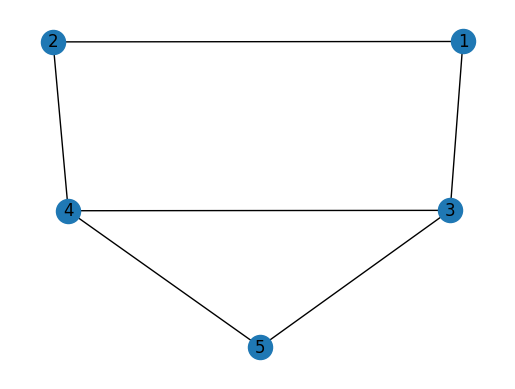

In [121]:
# Create empty graph
G = nx.Graph()

# Add edges to the graph (also adds nodes)
# Add the edges as an array of tuples - hint look at max-cut-graph.png for the structure e.g. [(1,2), (1,3 etc etc
G.add_edges_from([(1,2), (1,3), (2,4), (3,4), (3,5), (4,5)])

# plot graph
# pos = nx.spring_layout(G)
get_graph(G)

In [122]:
# ------- Set up the QUBO dictionary -------

# Initialize our Q matrix
Q = defaultdict(int)

# Update Q matrix for every edge in the graph
for u, v in G.edges:
    Q[(u,u)]+= -1
    Q[(v,v)]+= -1
    Q[(u,v)]+= 2

# print Q matrix
# Take the time to examine how the Q matrix looks vs what bias we're trying to introduce in the graph.
print('Show Q matrix:', Q)

Show Q matrix: defaultdict(<class 'int'>, {(1, 1): -2, (2, 2): -2, (1, 2): 2, (3, 3): -3, (1, 3): 2, (4, 4): -3, (2, 4): 2, (3, 4): 2, (5, 5): -2, (3, 5): 2, (4, 5): 2})


## SOLVING THE MAXCUT PROBLEM ON DWAVE

In [123]:
# ------- Run the QUBO problem on the QPU -------

# Set up QPU parameters
chainstrength = 8
numruns = 10

# set sampler
sampler = EmbeddingComposite(DWaveSampler())

response = sampler.sample_qubo(Q, chain_strength=chainstrength, num_reads=numruns, label='Maximum Cut QUBO')

In [124]:
energies = iter(response.data())

In [125]:
# ------- Print results to user -------
print('-' * 60)
print('{:>15s}{:>15s}{:^15s}{:^15s}'.format('Set 0','Set 1','Energy','Cut Size'))
print('-' * 60)
for line in response:
    S0 = [k for k,v in line.items() if v == 0]
    S1 = [k for k,v in line.items() if v == 1]
    E = next(energies).energy
    print('{:>15s}{:>15s}{:^15s}{:^15s}'.format(str(S0),str(S1),str(E),str(int(-1*E))))

------------------------------------------------------------
          Set 0          Set 1    Energy        Cut Size    
------------------------------------------------------------
      [1, 4, 5]         [2, 3]     -5.0             5       
         [1, 4]      [2, 3, 5]     -5.0             5       
      [2, 3, 5]         [1, 4]     -5.0             5       
         [2, 3]      [1, 4, 5]     -5.0             5       


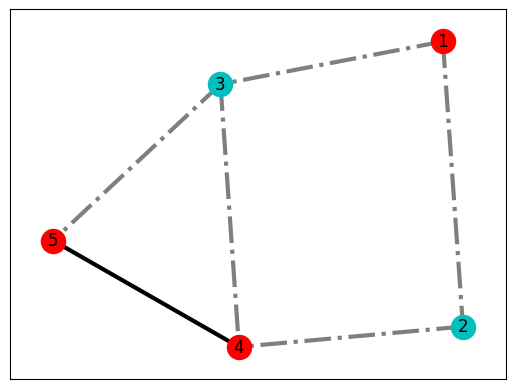

In [126]:
# ------- Display best results -------
# "best" result is the result with the lowest energy
# the look up table (lut) is a dictionary, where the key is the node index
# and the value is the set label. For example, lut[5] = 1, indicates that node 5 is in set 1 (S1).

lut = response.lowest().first.sample

# Interpret best result in terms of nodes and edges
S0 = [node for node in G.nodes if not lut[node]]
S1 = [node for node in G.nodes if lut[node]]
cut_edges = [(u, v) for u, v in G.edges if lut[u]!=lut[v]]
uncut_edges = [(u, v) for u, v in G.edges if lut[u]==lut[v]]

# Display best result
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, nodelist=S0, node_color='r')
nx.draw_networkx_nodes(G, pos, nodelist=S1, node_color='c')
nx.draw_networkx_edges(G, pos, edgelist=cut_edges, style='dashdot', alpha=0.5, width=3)
nx.draw_networkx_edges(G, pos, edgelist=uncut_edges, style='solid', width=3)
nx.draw_networkx_labels(G, pos)
plt.show();

In [127]:
# filename = "maxcut_plot.png"
# plt.savefig(filename, bbox_inches='tight')
# print("\nYour plot is saved to {}".format(filename))

__DISCUSSION__: The optimal cut size for this toy problem is 5. For every edge connecting nodes of different color we score a point (i.e., cut this edge), as displayed above by dashed lines. Here at maximum we can cut five edges. In this toy example we find multiple optimal degenerate solutions, apart from the obvious $\mathbb{Z}_2$ symmetry (that is, the color choice for the two subsets is arbitrary), because there is no preferred coloring for node 5. This problem is equivalent to finding the antiferromagnetic ground state, in the presence of frustration (as present here in the subgraph with nodes 3-4-5). 

In [128]:
# ------- Set up Ising parameters -------

# Initialize the h vector, J matrix
h = defaultdict(int)
J = defaultdict(int)

# Update J matrix for every edge in the graph
for i, j in G.edges:
    J[(i,j)]+= 1

In [129]:
# ------- Run the QUBO on the QPU -------

# Set up QPU parameters
chainstrength = 2
numruns = 10

sampler = EmbeddingComposite(DWaveSampler())
response = sampler.sample_ising(h, J, chain_strength=chainstrength, num_reads=numruns, label='Maximum Cut Ising')

In [130]:
# ------- Print results to user -------
print('-' * 60)
print('{:>15s}{:>15s}{:^15s}{:^15s}'.format('Set 0','Set 1','Energy','Cut Size'))
print('-' * 60)
for sample, E in response.data(fields=['sample','energy']):
    S0 = [k for k,v in sample.items() if v == -1]
    S1 = [k for k,v in sample.items() if v == 1]
    print('{:>15s}{:>15s}{:^15s}{:^15s}'.format(str(S0),str(S1),str(E),str(int((6-E)/2))))

------------------------------------------------------------
          Set 0          Set 1    Energy        Cut Size    
------------------------------------------------------------
         [1, 4]      [2, 3, 5]     -4.0             5       
      [1, 4, 5]         [2, 3]     -4.0             5       
      [2, 3, 5]         [1, 4]     -4.0             5       


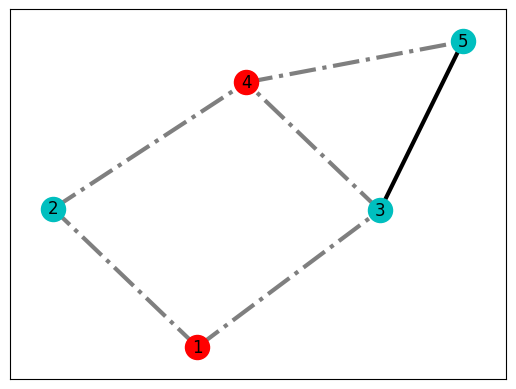

In [132]:
lut = response.first.sample

# Interpret best result in terms of nodes and edges
S0 = [node for node in G.nodes if lut[node]==-1]
S1 = [node for node in G.nodes if lut[node]==1]
cut_edges = [(u, v) for u, v in G.edges if lut[u]!=lut[v]]
uncut_edges = [(u, v) for u, v in G.edges if lut[u]==lut[v]]

# Display best result
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, nodelist=S0, node_color='r')
nx.draw_networkx_nodes(G, pos, nodelist=S1, node_color='c')
nx.draw_networkx_edges(G, pos, edgelist=cut_edges, style='dashdot', alpha=0.5, width=3)
nx.draw_networkx_edges(G, pos, edgelist=uncut_edges, style='solid', width=3)
nx.draw_networkx_labels(G, pos)
plt.show();

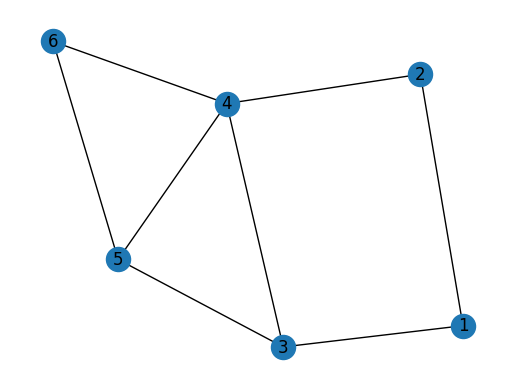

In [115]:
# Create empty graph
G6 = nx.Graph()

# Add edges to the graph (also adds nodes)
# Add the edges as an array of tuples - hint look at max-cut-graph.png for the structure e.g. [(1,2), (1,3 etc etc
G6.add_edges_from([(1,2), (1,3), (2,4), (3,4), (3,5), (4,5), (4,6), (5,6)])

# plot graph
# pos = nx.spring_layout(G)
get_graph(G6)